In [1]:
from jax import random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.nested_sampling import NestedSampler
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

In [2]:
ndims = 15
data_mu = jnp.arange(ndims)
data_cov = jnp.diag(jnp.ones(ndims)) ** 2
data_cov = jnp.where(data_cov == 0., 0.95, data_cov)

In [3]:
prior_mu = 2 * jnp.ones(ndims)
prior_cov = jnp.diag(jnp.ones(ndims)) ** 2
post_mu = prior_cov @ jnp.linalg.inv(prior_cov + data_cov) @ data_mu + data_cov @ jnp.linalg.inv(
    prior_cov + data_cov) @ prior_mu
post_cov = prior_cov @ jnp.linalg.inv(prior_cov + data_cov) @ data_cov
print("post mu", post_mu)
print("post_std", jnp.sqrt(jnp.diag(post_cov)))

post mu [-4.33986928 -3.38748833 -2.43510738 -1.48272642 -0.53034547  0.42203548
  1.37441643  2.32679739  3.27917834  4.23155929  5.18394024  6.1363212
  7.08870215  8.0410831   8.99346405]
post_std [0.32673202 0.32673202 0.32673202 0.32673202 0.32673202 0.32673202
 0.32673202 0.32673202 0.32673202 0.32673202 0.32673202 0.32673202
 0.32673202 0.32673202 0.32673202]


Number of weighted samples: 32069
Effective sample size: 3984.9

                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -4.22      0.25     -4.21     -4.57     -3.77  99810.20      1.00
      x[1]     -3.05      0.29     -3.06     -3.45     -2.75  97842.97      1.00
      x[2]      0.64      0.04      0.61      0.61      0.69  98935.43      1.00
      x[3]      1.44      0.10      1.36      1.36      1.57  98935.43      1.00
      x[4]      1.94      0.03      1.97      1.90      1.97  98935.73      1.00
      x[5]      2.80      0.06      2.75      2.75      2.87  98935.84      1.00
      x[6]      3.41      0.02      3.43      3.39      3.43  98936.67      1.00
      x[7]      2.73      0.01      2.72      2.72      2.74  98935.30      1.00
      x[8]      1.63      0.02      1.61      1.61      1.65  98935.74      1.00
      x[9]      2.67      0.01      2.67      2.66      2.67  98936.80      1.00
     x[10]      3.54      0.06      3.49    

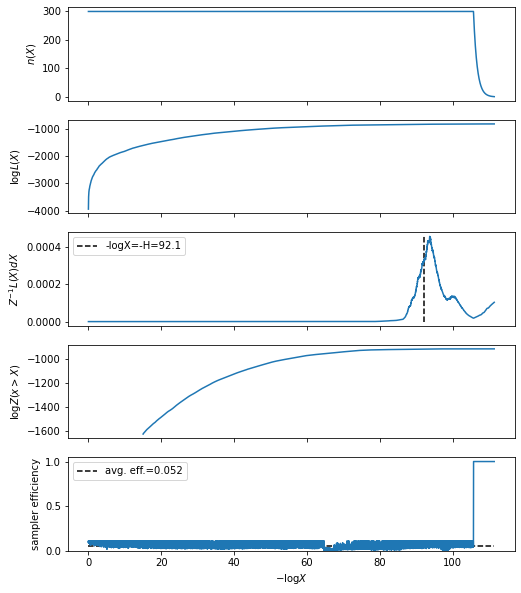

In [4]:
def model():
    x = numpyro.sample("x", dist.Normal(2, 1).expand([ndims]))
    numpyro.sample("obs", dist.MultivariateNormal(x, data_cov), obs=data_mu)


ns = NestedSampler(model, num_live_points=300, sampler_kwargs=dict(num_slices=3))
ns.run(random.PRNGKey(0))
print_summary(ns.get_samples(random.PRNGKey(1), 100000), group_by_chain=False)
ns.diagnostics(cornerplot=False)

In [5]:
mcmc = MCMC(NUTS(model, dense_mass=True), num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(0))
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:05<00:00, 344.36it/s, 7 steps of size 5.95e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      x[0]     -4.34      0.32     -4.35     -4.88     -3.85   2195.02      1.00
      x[1]     -3.39      0.31     -3.39     -3.87     -2.86   2516.92      1.00
      x[2]     -2.43      0.30     -2.45     -2.93     -1.94   2245.76      1.00
      x[3]     -1.49      0.33     -1.48     -2.08     -1.01   1972.94      1.00
      x[4]     -0.53      0.33     -0.54     -1.05      0.01   2000.02      1.00
      x[5]      0.43      0.32      0.42     -0.16      0.87   2047.72      1.00
      x[6]      1.38      0.34      1.38      0.82      1.92   2462.96      1.00
      x[7]      2.32      0.33      2.32      1.80      2.88   1918.28      1.00
      x[8]      3.28      0.33      3.29      2.72      3.78   1712.81      1.00
      x[9]      4.23      0.33      4.23      3.69      4.76   3393.63      1.00
     x[10]      5.18      0.32      5.17      4.69      5.72   2238.66      1.00
     x[11]      6.14      0